## Approach

1. Identify available dates and temporal frequency of observations for the given collection using the GHGC API `/stac` endpoint. The collection processed in this notebook is the gridded methane emissions data product.
2. Pass the STAC item into the raster API `/stac/tilejson.json `endpoint.
3. Using `folium.plugins.DualMap`, we will visualize two tiles (side-by-side), allowing us to compare time points. 
4. After the visualization, we will perform zonal statistics for a given polygon.

   

## About the Data

The gridded EPA U.S. anthropogenic methane greenhouse gas inventory (gridded GHGI) includes spatially disaggregated (0.1 deg x 0.1 deg or approximately 10 x 10 km resolution) maps of annual anthropogenic methane emissions (for the contiguous United States (CONUS), consistent with national annual U.S. anthropogenic methane emissions reported in the U.S. EPA [Inventory of U.S. Greenhouse Gas Emissions and Sinks](https://www.epa.gov/ghgemissions/inventory-us-greenhouse-gas-emissions-and-sinks) (U.S. GHGI). This V2 Express Extension dataset contains methane emissions provided as fluxes, in units of molecules of methane per square cm per second, for over 25 individual emission source categories, including those from agriculture, petroleum and natural gas systems, coal mining, and waste. The data have been converted from their original NetCDF format to Cloud-Optimized GeoTIFF (COG) for use in the US GHG Center, thereby enabling user exploration of spatial anthropogenic methane emissions and their trends.

For more information regarding this dataset, please visit the [U.S. Gridded Anthropogenic Methane Emissions Inventory](https://earth.gov/ghgcenter/data-catalog/epa-ch4emission-yeargrid-v2express) data overview page.

# Install the Required Libraries
Required libraries are pre-installed on the GHG Center Hub. If you need to run this notebook elsewhere, please install them with this line in a code cell:

%pip install requests folium rasterstats pystac_client pandas matplotlib --quiet

## Querying the STAC API
First, we are going to import the required libraries. Once imported, they allow better executing a query in the GHG Center Spatio Temporal Asset Catalog (STAC) Application Programming Interface (API) where the granules for this collection are stored.

In [1]:
# Import the following libraries
import requests
import folium
import folium.plugins
from folium import Map, TileLayer
from pystac_client import Client
import branca
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Provide the STAC and RASTER API endpoints
# The endpoint is referring to a location within the API that executes a request on a data collection nesting on the server.

# The STAC API is a catalog of all the existing data collections that are stored in the GHG Center.
STAC_API_URL = "https://earth.gov/ghgcenter/api/stac"

# The RASTER API is used to fetch collections for visualization
RASTER_API_URL = "https://earth.gov/ghgcenter/api/raster"

# The collection name is used to fetch the dataset from the STAC API. First, we define the collection name as a variable
# Name of the collection for gridded methane dataset 
collection_name = "epa-ch4emission-yeargrid-v2express"

In [3]:
# Fetch the collection from the STAC API using the appropriate endpoint
# The 'requests' library allows a HTTP request possible
collection = requests.get(f"{STAC_API_URL}/collections/{collection_name}").json()

# Print the properties of the collection to the console
collection

{'id': 'epa-ch4emission-yeargrid-v2express',
 'type': 'Collection',
 'links': [{'rel': 'items',
   'type': 'application/geo+json',
   'href': 'https://earth.gov/ghgcenter/api/stac/collections/epa-ch4emission-yeargrid-v2express/items'},
  {'rel': 'parent',
   'type': 'application/json',
   'href': 'https://earth.gov/ghgcenter/api/stac/'},
  {'rel': 'root',
   'type': 'application/json',
   'href': 'https://earth.gov/ghgcenter/api/stac/'},
  {'rel': 'self',
   'type': 'application/json',
   'href': 'https://earth.gov/ghgcenter/api/stac/collections/epa-ch4emission-yeargrid-v2express'}],
 'title': 'U.S. Gridded Anthropogenic Methane Emissions Inventory v2 Express Extension',
 'extent': {'spatial': {'bbox': [[-180.0, -90.0, 180.0, 90.0]]},
  'temporal': {'interval': [['2012-01-01T00:00:00+00:00',
     '2020-12-31T00:00:00+00:00']]}},
 'license': 'CC-BY-4.0',
 'renders': {'dashboard': {'assets': ['total-methane'],
   'maxzoom': 5,
   'minzoom': 0,
   'rescale': [[0, 20]],
   'colormap_name':

Examining the contents of our `collection` under the `temporal` variable, we see that the data is available from January 2012 to December 2020. By looking at the `dashboard:time density`, we observe that the periodic frequency of these observations is yearly.

In [4]:
# Extracting the required temporal information
temporal_extent = collection['extent']['temporal']['interval'][0]
start_date = temporal_extent[0].split('T')[0]
end_date = temporal_extent[1].split('T')[0]
temporal_resolution = collection['dashboard:time_density']

# Final print statement
print(f"Start Date = {start_date}")
print(f"End Date = {end_date}")
print(f"Temporal Resolution = {temporal_resolution}")

Start Date = 2012-01-01
End Date = 2020-12-31
Temporal Resolution = year


In [5]:
# Create a function that would search for a data collection in the US GHG Center STAC API

# First, we need to define the function
# The name of the function = "get_item_count"
# The argument that will be passed through the defined function = "collection_id"
def get_item_count(collection_id):

    # Set a counter for the number of items existing in the collection
    count = 0

    # Define the path to retrieve the granules (items) of the collection of interest in the STAC API
    items_url = f"{STAC_API_URL}/collections/{collection_id}/items"

    # Run a while loop to make HTTP requests until there are no more URLs associated with the collection in the STAC API
    while True:

        # Retrieve information about the granules by sending a "get" request to the STAC API using the defined collection path
        response = requests.get(items_url)

        # If the items do not exist, print an error message and quit the loop
        if not response.ok:
            print("error getting items")
            exit()

        # Return the results of the HTTP response as JSON
        stac = response.json()

        # Increase the "count" by the number of items (granules) returned in the response
        count += int(stac["context"].get("returned", 0))

        # Retrieve information about the next URL associated with the collection in the STAC API (if applicable)
        next = [link for link in stac["links"] if link["rel"] == "next"]

        # Exit the loop if there are no other URLs
        if not next:
            break
        
        # Ensure the information gathered by other STAC API links associated with the collection are added to the original path
        # "href" is the identifier for each of the tiles stored in the STAC API
        items_url = next[0]["href"]

    # Return the information about the total number of granules found associated with the collection
    return count

In [6]:
# Apply the function created above "get_item_count" to the data collection
number_of_items = get_item_count(collection_name)

# Get the information about the number of granules found in the collection
items = requests.get(f"{STAC_API_URL}/collections/{collection_name}/items?limit={number_of_items}").json()["features"]

# Print the total number of items (granules) found
print(f"Found {len(items)} items")

Found 9 items


This makes sense as there are 9 years between 2012 - 2020, meaning 9 records in total.  

In [7]:
# Examine the first item in the collection
# Keep in mind that a list starts from 0, 1, 2... therefore items[0] is referring to the first item in the list/collection
items[0]

{'id': 'epa-ch4emission-yeargrid-v2express-2020',
 'bbox': [-129.99999694387628,
  19.99999923487448,
  -60.00000305612369,
  55.00000076512553],
 'type': 'Feature',
 'links': [{'rel': 'collection',
   'type': 'application/json',
   'href': 'https://earth.gov/ghgcenter/api/stac/collections/epa-ch4emission-yeargrid-v2express'},
  {'rel': 'parent',
   'type': 'application/json',
   'href': 'https://earth.gov/ghgcenter/api/stac/collections/epa-ch4emission-yeargrid-v2express'},
  {'rel': 'root',
   'type': 'application/json',
   'href': 'https://earth.gov/ghgcenter/api/stac/'},
  {'rel': 'self',
   'type': 'application/geo+json',
   'href': 'https://earth.gov/ghgcenter/api/stac/collections/epa-ch4emission-yeargrid-v2express/items/epa-ch4emission-yeargrid-v2express-2020'},
  {'title': 'Map of Item',
   'href': 'https://earth.gov/ghgcenter/api/raster/stac/map?collection=epa-ch4emission-yeargrid-v2express&item=epa-ch4emission-yeargrid-v2express-2020&assets=total-methane&maxzoom=5&minzoom=0&re

## Exploring Changes in Methane (CH4) Levels Using the Raster API

In this notebook, we will explore the impacts of methane emissions and by examining changes over time in urban regions. We will visualize the outputs on a map using `folium`.

In [8]:
# Now we create a dictionary where the start datetime values for each granule is queried more explicitly by year and month (e.g., 2020-02)
items = {item["properties"]["datetime"][:7]: item for item in items} 

# Next, we need to specify the asset name for this collection
# The asset name is referring to the raster band containing the pixel values for the parameter of interest
# For the case of the U.S. Gridded Anthropogenic Methane Emissions Inventory collection, the parameter of interest is “surface-coal”
asset_name = "surface-coal"

Below, we enter minimum and maximum values to provide our upper and lower bounds in `rescale_values`.

In [9]:
# Fetching the min and max values for a specific item
rescale_values = {"max":items[list(items.keys())[0]]["assets"][asset_name]["raster:bands"][0]["histogram"]["max"], "min":items[list(items.keys())[0]]["assets"][asset_name]["raster:bands"][0]["histogram"]["min"]}

In [10]:
items

{'2020-01': {'id': 'epa-ch4emission-yeargrid-v2express-2020',
  'bbox': [-129.99999694387628,
   19.99999923487448,
   -60.00000305612369,
   55.00000076512553],
  'type': 'Feature',
  'links': [{'rel': 'collection',
    'type': 'application/json',
    'href': 'https://earth.gov/ghgcenter/api/stac/collections/epa-ch4emission-yeargrid-v2express'},
   {'rel': 'parent',
    'type': 'application/json',
    'href': 'https://earth.gov/ghgcenter/api/stac/collections/epa-ch4emission-yeargrid-v2express'},
   {'rel': 'root',
    'type': 'application/json',
    'href': 'https://earth.gov/ghgcenter/api/stac/'},
   {'rel': 'self',
    'type': 'application/geo+json',
    'href': 'https://earth.gov/ghgcenter/api/stac/collections/epa-ch4emission-yeargrid-v2express/items/epa-ch4emission-yeargrid-v2express-2020'},
   {'title': 'Map of Item',
    'href': 'https://earth.gov/ghgcenter/api/raster/stac/map?collection=epa-ch4emission-yeargrid-v2express&item=epa-ch4emission-yeargrid-v2express-2020&assets=total

Now, we will pass the item id, collection name, asset name, and the `rescaling factor` to the `Raster API` endpoint. We will do this twice, once for January 2018 and again for January 2012, so that we can visualize each event independently.

In [11]:
# Choose a color map for displaying the first observation (event)
# Please refer to matplotlib library if you'd prefer choosing a different color ramp.
# For more information on Colormaps in Matplotlib, please visit https://matplotlib.org/stable/users/explain/colors/colormaps.html
color_map = "rainbow" 

# Make a GET request to retrieve information for the 2018 tile 
january_2018_tile = requests.get(

    # Pass the collection name, the item number in the list, and its ID
    f"{RASTER_API_URL}/stac/tilejson.json?collection={items['2018-01']['collection']}&item={items['2018-01']['id']}"

    # Pass the asset name
    f"&assets={asset_name}"

    # Pass the color formula and colormap for custom visualization
    f"&color_formula=gamma+r+1.05&colormap_name={color_map}"

    # Pass the minimum and maximum values for rescaling
    f"&rescale={rescale_values['min']},{rescale_values['max']}", 

# Return the response in JSON format
).json()

# Print the properties of the retrieved granule to the console
january_2018_tile

{'tilejson': '2.2.0',
 'version': '1.0.0',
 'scheme': 'xyz',
 'tiles': ['https://earth.gov/ghgcenter/api/raster/stac/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?collection=epa-ch4emission-yeargrid-v2express&item=epa-ch4emission-yeargrid-v2express-2018&assets=surface-coal&color_formula=gamma+r+1.05&colormap_name=rainbow&rescale=-9999.0%2C569.109130859375'],
 'minzoom': 0,
 'maxzoom': 24,
 'bounds': [-129.99999694387628,
  19.99999923487448,
  -60.00000305612369,
  55.00000076512553],
 'center': [-94.99999999999999, 37.5, 0]}

In [12]:
# Make a GET request to retrieve information for the 2012 tile 
january_2012_tile = requests.get(

    # Pass the collection name, the item number in the list, and its ID
    f"{RASTER_API_URL}/stac/tilejson.json?collection={items['2012-01']['collection']}&item={items['2012-01']['id']}"

    # Pass the asset name
    f"&assets={asset_name}"

    # Pass the color formula and colormap for custom visualization
    f"&color_formula=gamma+r+1.05&colormap_name={color_map}"

    # Pass the minimum and maximum values for rescaling
    f"&rescale={rescale_values['min']},{rescale_values['max']}", 

# Return the response in JSON format
).json()

# Print the properties of the retrieved granule to the console
january_2012_tile

{'tilejson': '2.2.0',
 'version': '1.0.0',
 'scheme': 'xyz',
 'tiles': ['https://earth.gov/ghgcenter/api/raster/stac/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?collection=epa-ch4emission-yeargrid-v2express&item=epa-ch4emission-yeargrid-v2express-2012&assets=surface-coal&color_formula=gamma+r+1.05&colormap_name=rainbow&rescale=-9999.0%2C569.109130859375'],
 'minzoom': 0,
 'maxzoom': 24,
 'bounds': [-129.99999694387628,
  19.99999923487448,
  -60.00000305612369,
  55.00000076512553],
 'center': [-94.99999999999999, 37.5, 0]}

## Visualizing CH₄ emissions


In [13]:
# Set initial zoom and center of map for CH₄ Layer
# Centre of map [latitude,longitude]
# 'folium.plugins' allows mapping side-by-side
map_ = folium.plugins.DualMap(location=(34, -118), zoom_start=6)

# Define the first map layer (January 2018)
map_layer_2018 = TileLayer(
    tiles=january_2018_tile["tiles"][0], # Path to retrieve the tile
    attr="GHG", # Set the attribution
    opacity=0.7, # Adjust the transparency of the layer
)

# Add the first layer to the Dual Map
map_layer_2018.add_to(map_.m1)

# Define the second map layer (January 2012)
map_layer_2012 = TileLayer(
    tiles=january_2012_tile["tiles"][0], # Path to retrieve the tile
    attr="GHG", # Set the attribution
    opacity=0.7, # Adjust the transparency of the layer
)

# Add the second layer to the Dual Map
map_layer_2012.add_to(map_.m2)

# Visualize the Dual Map
map_

# Calculating Zonal Statistics

To perform zonal statistics, first we need to create a polygon. In this use case we are creating a polygon in Texas (USA).

In [14]:
# Texas, USA
texas_aoi = {
    "type": "Feature", # Create a feature object
    "properties": {},
    "geometry": { # Set the bounding coordinates for the polygon
        "coordinates": [
            [
                # [13.686159004559698, -21.700046934333145],
                # [13.686159004559698, -23.241974326585833],
                # [14.753560168039911, -23.241974326585833],
                # [14.753560168039911, -21.700046934333145],
                # [13.686159004559698, -21.700046934333145],
                [-95, 29], # South-east bounding coordinate
                [-95, 33], # North-east bounding coordinate
                [-104,33], # North-west bounding coordinate
                [-104,29], # South-west bounding coordinate
                [-95, 29]  # South-east bounding coordinate (closing the polygon)
            ]
        ],
        "type": "Polygon",
    },
}

In [15]:
# Create a new map to display the generated polygon
# We'll plug in the coordinates for a location
# Central to the study area and a reasonable zoom level
aoi_map = Map(

    # Base map is set to OpenStreetMap
    tiles="OpenStreetMap",

    # Define the spatial properties for the map
    location=[
        30,-100
    ],

    # Set the zoom value
    zoom_start=6,
)

# Insert the polygon to the map
folium.GeoJson(texas_aoi, name="Texas, USA").add_to(aoi_map)

# Visualize the map
aoi_map

In [16]:
# Check total number of items available within the collection
items = requests.get(
    f"{STAC_API_URL}/collections/{collection_name}/items?limit=300"
).json()["features"]

# Print the total number of items (granules) found
print(f"Found {len(items)} items")

Found 9 items


In [17]:
# Examine the first item in the collection
items[0]

{'id': 'epa-ch4emission-yeargrid-v2express-2020',
 'bbox': [-129.99999694387628,
  19.99999923487448,
  -60.00000305612369,
  55.00000076512553],
 'type': 'Feature',
 'links': [{'rel': 'collection',
   'type': 'application/json',
   'href': 'https://earth.gov/ghgcenter/api/stac/collections/epa-ch4emission-yeargrid-v2express'},
  {'rel': 'parent',
   'type': 'application/json',
   'href': 'https://earth.gov/ghgcenter/api/stac/collections/epa-ch4emission-yeargrid-v2express'},
  {'rel': 'root',
   'type': 'application/json',
   'href': 'https://earth.gov/ghgcenter/api/stac/'},
  {'rel': 'self',
   'type': 'application/geo+json',
   'href': 'https://earth.gov/ghgcenter/api/stac/collections/epa-ch4emission-yeargrid-v2express/items/epa-ch4emission-yeargrid-v2express-2020'},
  {'title': 'Map of Item',
   'href': 'https://earth.gov/ghgcenter/api/raster/stac/map?collection=epa-ch4emission-yeargrid-v2express&item=epa-ch4emission-yeargrid-v2express-2020&assets=total-methane&maxzoom=5&minzoom=0&re

Now that we created the polygon for the area of interest, we need to develop a function that runs through the data collection and generates the statistics for a specific item (granule) within the boundaries of the AOI polygon.

In [18]:
# The bounding box should be passed to the geojson param as a geojson Feature or FeatureCollection
# Create a function that retrieves information regarding a specific granule using its asset name and raster identifier and generates the statistics for it
# The function takes an item (granule) and a JSON (polygon) as input parameters
def generate_stats(item, geojson):

    # A POST request is made to submit the data associated with the item of interest (specific observation) within the boundaries of the polygon to compute its statistics
    result = requests.post(

        # Raster API Endpoint for computing statistics
        f"{RASTER_API_URL}/cog/statistics",

        # Pass the URL to the item, asset name, and raster identifier as parameters
        params={"url": item["assets"][asset_name]["href"]},

        # Send the GeoJSON object (polygon) along with the request
        json=geojson,

    # Return the response in JSON format
    ).json()

    # Return a dictionary containing the computed statistics along with the item's datetime information.
    return {
        **result["properties"],
        "datetime": item["properties"]["datetime"],
    }

With the function above we can generate the statistics for the AOI.

In [19]:
%%time
# %%time = Wall time (execution time) for running the code below

# Generate statistics using the created function "generate_stats" within the bounding box defined by the polygon
stats = [generate_stats(item, texas_aoi) for item in items]

CPU times: user 106 ms, sys: 14.7 ms, total: 121 ms
Wall time: 5.66 s


In [20]:
# Print the stats for the first item in the collection
stats[0]

{'statistics': {'b1': {'min': 0.23683340847492218,
   'max': 22.17084503173828,
   'mean': 9.193571090698242,
   'count': 3.0,
   'sum': 27.580713272094727,
   'std': 9.39498967501574,
   'median': 5.173033714294434,
   'majority': 0.23683340847492218,
   'minority': 0.23683340847492218,
   'unique': 3.0,
   'histogram': [[1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0],
    [0.23683340847492218,
     2.430234670639038,
     4.623635768890381,
     6.817037105560303,
     9.010437965393066,
     11.203839302062988,
     13.39724063873291,
     15.590641975402832,
     17.784042358398438,
     19.97744369506836,
     22.17084503173828]],
   'valid_percent': 0.08,
   'masked_pixels': 3597.0,
   'valid_pixels': 3.0,
   'percentile_2': 0.23683340847492218,
   'percentile_98': 22.17084503173828}},
 'datetime': '2020-01-01T00:00:00+00:00'}

Create a function that goes through every single item in the collection and populates their properties - including the minimum, maximum, and sum of their values - in a table.

In [21]:
# Create a function that converts statistics in JSON format into a pandas DataFrame
def clean_stats(stats_json) -> pd.DataFrame:

    # Normalize the JSON data
    df = pd.json_normalize(stats_json)

    # Replace the naming "statistics.b1" in the columns
    df.columns = [col.replace("statistics.b1.", "") for col in df.columns]

    # Set the datetime format
    df["date"] = pd.to_datetime(df["datetime"])

    # Return the cleaned format
    return df

# Apply the generated function on the stats data
df = clean_stats(stats)

# Display the stats for the first 5 granules in the collection in the table
# Change the value in the parenthesis to show more or a smaller number of rows in the table
df.head(5)

,datetime,min,max,mean,count,sum,std,median,majority,minority,unique,histogram,valid_percent,masked_pixels,valid_pixels,percentile_2,percentile_98,date
0,2020-01-01T00:00:00+00:00,0.236833,22.170845,9.193571,3.0,27.580713,9.394990,5.173034,0.236833,0.236833,3.0,"[[1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.08,3597.0,3.0,0.236833,22.170845,2020-01-01 00:00:00+00:00
1,2019-01-01T00:00:00+00:00,0.311410,29.152185,12.088519,3.0,36.265556,12.353363,6.801961,0.311410,0.311410,3.0,"[[1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.08,3597.0,3.0,0.311410,29.152185,2019-01-01 00:00:00+00:00
2,2018-01-01T00:00:00+00:00,0.341802,31.997334,13.268314,3.0,39.804943,13.559006,7.465808,0.341802,0.341802,3.0,"[[1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.08,3597.0,3.0,0.341802,31.997334,2018-01-01 00:00:00+00:00
3,2017-01-01T00:00:00+00:00,4.555885,40.591602,19.690639,4.0,78.762558,14.679013,7.337633,4.555885,4.555885,4.0,"[[2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0,...",0.11,3596.0,4.0,4.555885,40.591602,2017-01-01 00:00:00+00:00
4,2016-01-01T00:00:00+00:00,4.969536,34.220993,17.191929,5.0,85.959641,11.040686,13.514935,4.969536,4.969536,5.0,"[[2.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0,...",0.14,3595.0,5.0,4.969536,34.220993,2016-01-01 00:00:00+00:00


## Visualizing the Data as a Time Series
We can now explore the gridded methane emission (Domestic Wastewater Treatment & Discharge (5D)) time series (January 2000 -December 2021) available for the Dallas, Texas area of the U.S. We can plot the data set using the code below:

Text(0.5, 1.0, 'CH4 gridded methane emission from Domestic Wastewater Treatment & Discharge (5D) for Texas, Dallas (2012-202)')

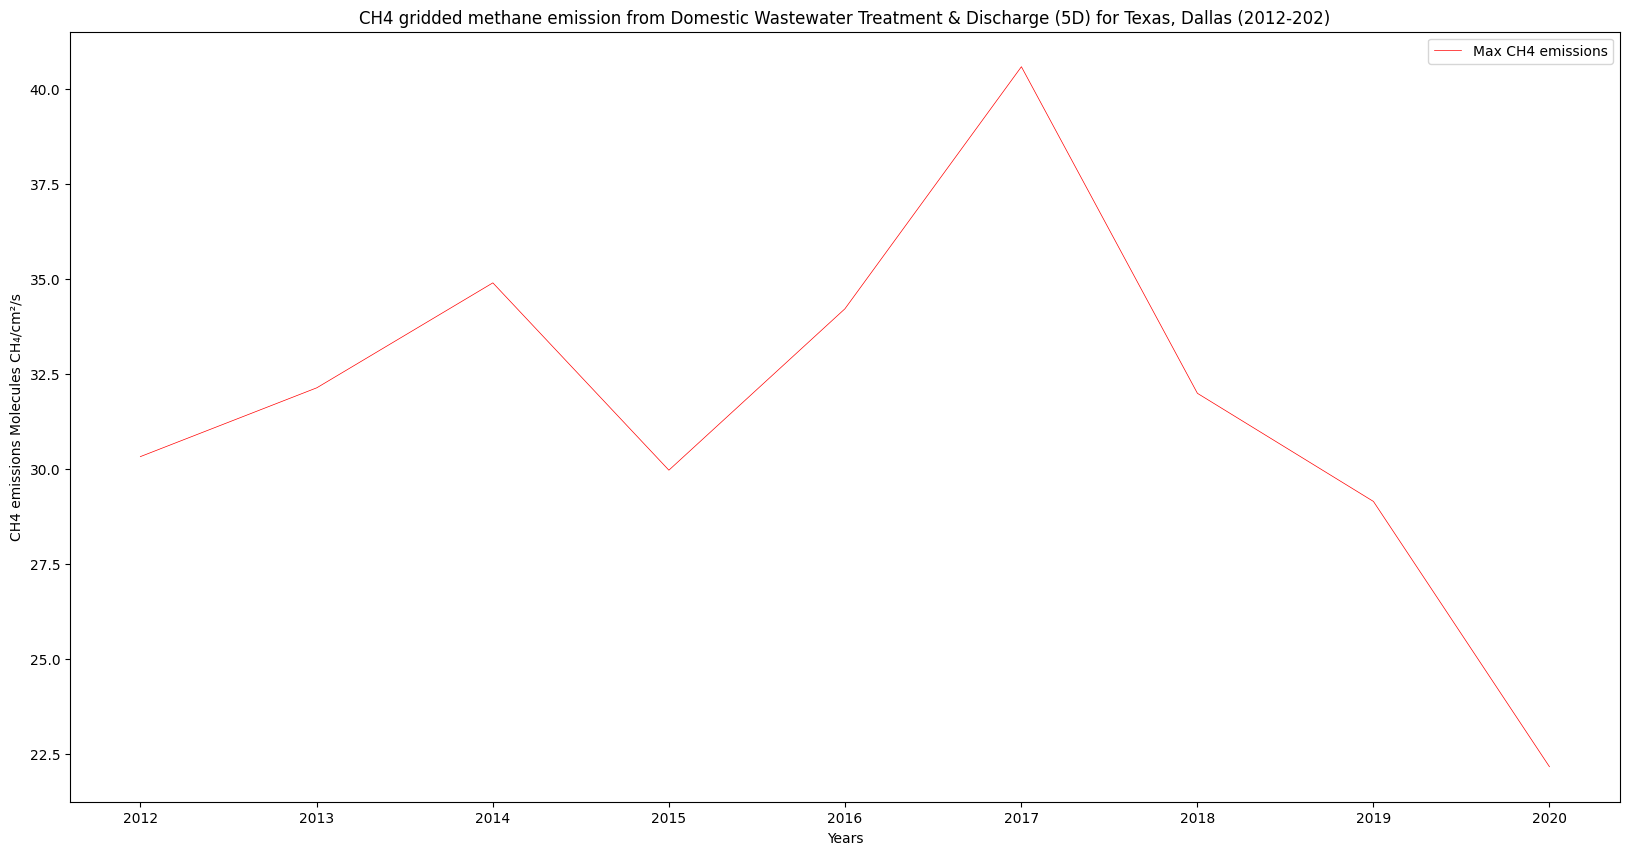

In [22]:
# Figure size: 20 representing the width, 10 representing the height
fig = plt.figure(figsize=(20, 10))


plt.plot(
    df["date"], # X-axis: sorted date
    df["max"],  # Y-axis: maximum CH4 emission
    color="red", # Line color
    linestyle="-", # Line style
    linewidth=0.5, # Line width
    label="Max CH4 emissions", # Legend label
)

# Display legend
plt.legend()

# Insert label for the X-axis
plt.xlabel("Years")

# Insert label for the Y-axis
plt.ylabel("CH4 emissions Molecules CH₄/cm²/s")

# Insert title for the plot
plt.title("CH4 gridded methane emission from Domestic Wastewater Treatment & Discharge (5D) for Texas, Dallas (2012-202)")

In [23]:
# Print the properties for the 3rd item in the collection
print(items[2]["properties"]["datetime"])

2018-01-01T00:00:00+00:00


In [24]:
# A GET request is made for the 2016 tile
tile_2016 = requests.get(

    # Pass the collection name, the item number in the list, and its ID
    f"{RASTER_API_URL}/stac/tilejson.json?collection={items[2]['collection']}&item={items[2]['id']}"

    # Pass the asset name
    f"&assets={asset_name}"

    # Pass the color formula and colormap for custom visualization
    f"&color_formula=gamma+r+1.05&colormap_name={color_map}"

    # Pass the minimum and maximum values for rescaling
    f"&rescale={rescale_values['min']},{rescale_values['max']}",

# Return the response in JSON format
).json()

# Print the properties of the retrieved granule to the console
tile_2016

{'tilejson': '2.2.0',
 'version': '1.0.0',
 'scheme': 'xyz',
 'tiles': ['https://earth.gov/ghgcenter/api/raster/stac/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?collection=epa-ch4emission-yeargrid-v2express&item=epa-ch4emission-yeargrid-v2express-2018&assets=surface-coal&color_formula=gamma+r+1.05&colormap_name=rainbow&rescale=-9999.0%2C569.109130859375'],
 'minzoom': 0,
 'maxzoom': 24,
 'bounds': [-129.99999694387628,
  19.99999923487448,
  -60.00000305612369,
  55.00000076512553],
 'center': [-94.99999999999999, 37.5, 0]}

In [25]:
# Create a new map to display the 2016 tile
aoi_map_bbox = Map(

    # Base map is set to OpenStreetMap
    tiles="OpenStreetMap",

    # Set the center of the map
    location=[
        30,-100
    ],

    # Set the zoom value
    zoom_start=8,
)

# Define the map layer
map_layer = TileLayer(

    # Path to retrieve the tile
    tiles=tile_2016["tiles"][0],

    # Set the attribution and adjust the transparency of the layer
    attr="GHG", opacity = 0.5
)

# Add the layer to the map
map_layer.add_to(aoi_map_bbox)

# Visualize the map
aoi_map_bbox

## Summary

In this notebook we have successfully completed the following steps for the STAC collection for the U.S. Gridded Anthropogenic Methane Emissions Inventory dataset:

1.  Install and import the necessary libraries
2.  Fetch the collection from STAC collections using the appropriate endpoints
3.  Count the number of existing granules within the collection
4.  Map and compare the anthropogenic methane emissions for two distinctive months/years
5.  Generate zonal statistics for the area of interest (AOI)
6.  Generate a time-series graph of the anthropogenic methane emissions for a specified region

If you have any questions regarding this user notebook, please contact us using the [feedback form](https://docs.google.com/forms/d/e/1FAIpQLSeVWCrnca08Gt_qoWYjTo6gnj1BEGL4NCUC9VEiQnXA02gzVQ/viewform).